<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/fall_2025_iub/content/lessons/12_spectral_analysis_continued/12_workalong_01_filter.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Work-along: Simple filtering

<div style="max-width:720px"><div style="position:relative;padding-bottom:56.25%"><iframe id="kaltura_player" src='https://cdnapisec.kaltura.com/p/1751071/embedPlaykitJs/uiconf_id/55382703?iframeembed=true&amp;entry_id=1_x4efnbnj&amp;config%5Bprovider%5D=%7B%22widgetId%22%3A%221_faci07dv%22%7D&amp;config%5Bplayback%5D=%7B%22startTime%22%3A0%7D'  allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-downloads allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" title="EAS-G 690 Lesson 12 - Simple Filtering" style="position:absolute;top:0;left:0;width:100%;height:100%;border:0"></iframe></div></div>

*Use [this link](https://iu.mediaspace.kaltura.com/media/t/1_x4efnbnj/388761952) if you have issues viewing the embeded video above.*

This notebook demonstrates using the FFT to filter timeseries data.  It also demonstrates a higher-quality approach using a [Butterworth fitler](https://en.wikipedia.org/wiki/Butterworth_filter).

In [2]:
""" Import libraries. """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_497821/798249715.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(streamflow_file, skiprows=skiprows, delim_whitespace=True,


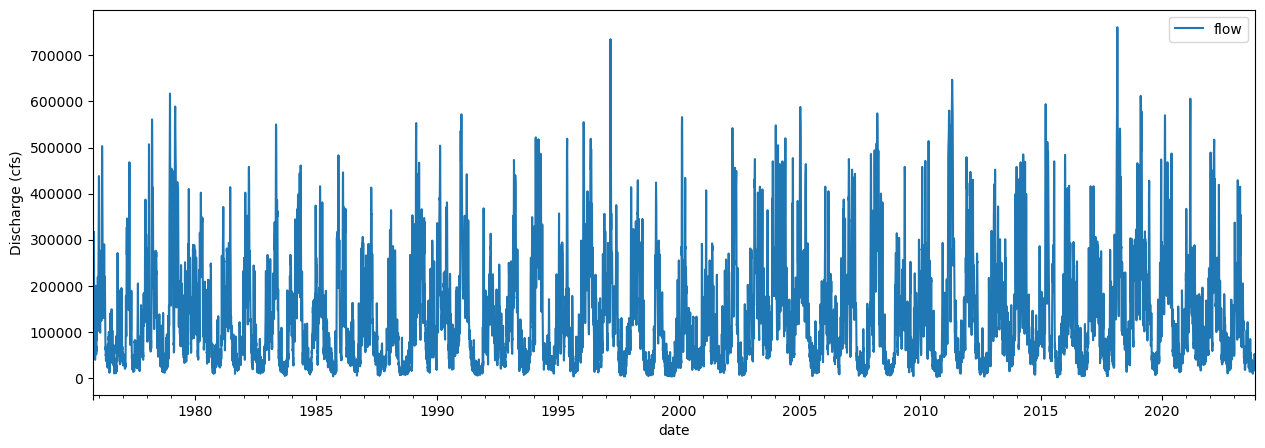

In [6]:
""" Load the data file. """
skiprows = 30 

streamflow_file = "./cannelton_flow.dat" 

# load the data
data = pd.read_csv(streamflow_file, skiprows=skiprows, delim_whitespace=True, 
                   names=['org', 'id', 'date', 'flow', 'flag'], 
                   parse_dates=['date']
                   )

fig, ax = plt.subplots()
data.plot(ax = ax, x = 'date', y='flow', figsize=(15,5))
ax.set_ylabel('Discharge (cfs)')
plt.show()


In [10]:
""" Filter the data using a naive cutoff filter. """
# calculate the fft
flow_fft = np.fft.rfft(data['flow'])

# convert our data times to seconds
dt = 60 * 60 * 24 # seconds

# calculate the frequencies
freq = np.fft.rfftfreq(len(data['flow']), dt)

# convert from frequency to period for plotting and filtering 
periods = 1/freq
# convert period to years 
periods = periods / (60*60*24*365.25)



/tmp/ipykernel_497821/3070418962.py:12: RuntimeWarning: divide by zero encountered in divide
  periods = 1/freq


In [12]:
# ********************************************************************
# find frequencies with periods less than half a year
ifilter = periods < 0.5 # years 

# zero the fft at those frequencies (i.e., apply the filter)
filtered_flow_fft = flow_fft.copy()
filtered_flow_fft[ifilter] = 0 

# convert back to the time domain 
filtered_flow = np.fft.irfft(filtered_flow_fft)
filtered_flow
# *******************************************************************

array([56740.47206967, 57003.689829  , 57285.69825085, ...,
       56054.61913823, 56266.83805089, 56495.15422025], shape=(17572,))

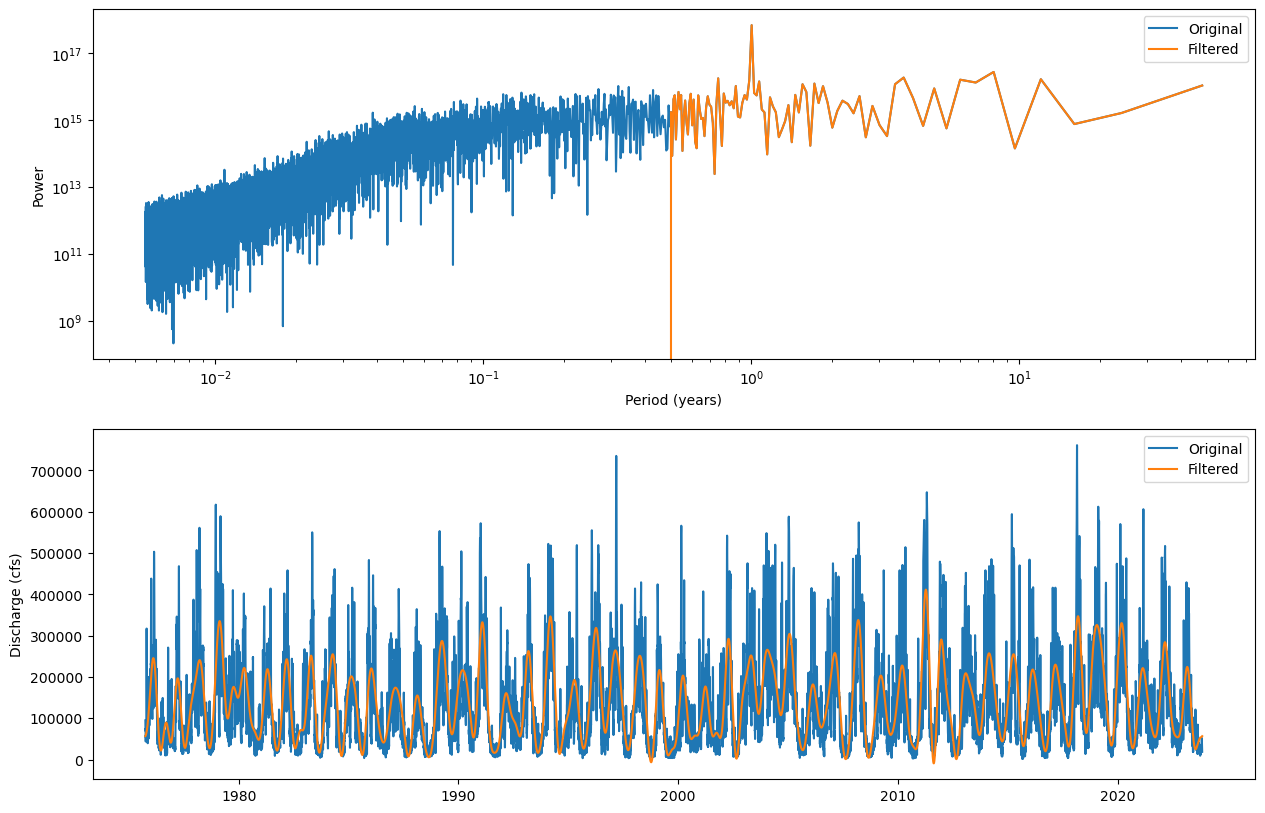

In [16]:
# plot the power spectrum and timeseries
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# the power spectrum 
ax = axs[0]
ax.plot(periods, np.abs(flow_fft * np.conj(flow_fft)), label = 'Original')
ax.plot(periods, np.abs(filtered_flow_fft * np.conj(filtered_flow_fft)), label = 'Filtered')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Period (years)")
ax.set_ylabel("Power")
ax.legend()

# the time series 
ax = axs[1]
ax.plot(data['date'], data['flow'], label = 'Original')
ax.plot(data['date'], filtered_flow, label = 'Filtered')
ax.set_ylabel('Discharge (cfs)')
ax.legend()


plt.show()
# for the original and filtered data 
# ********************************************************************

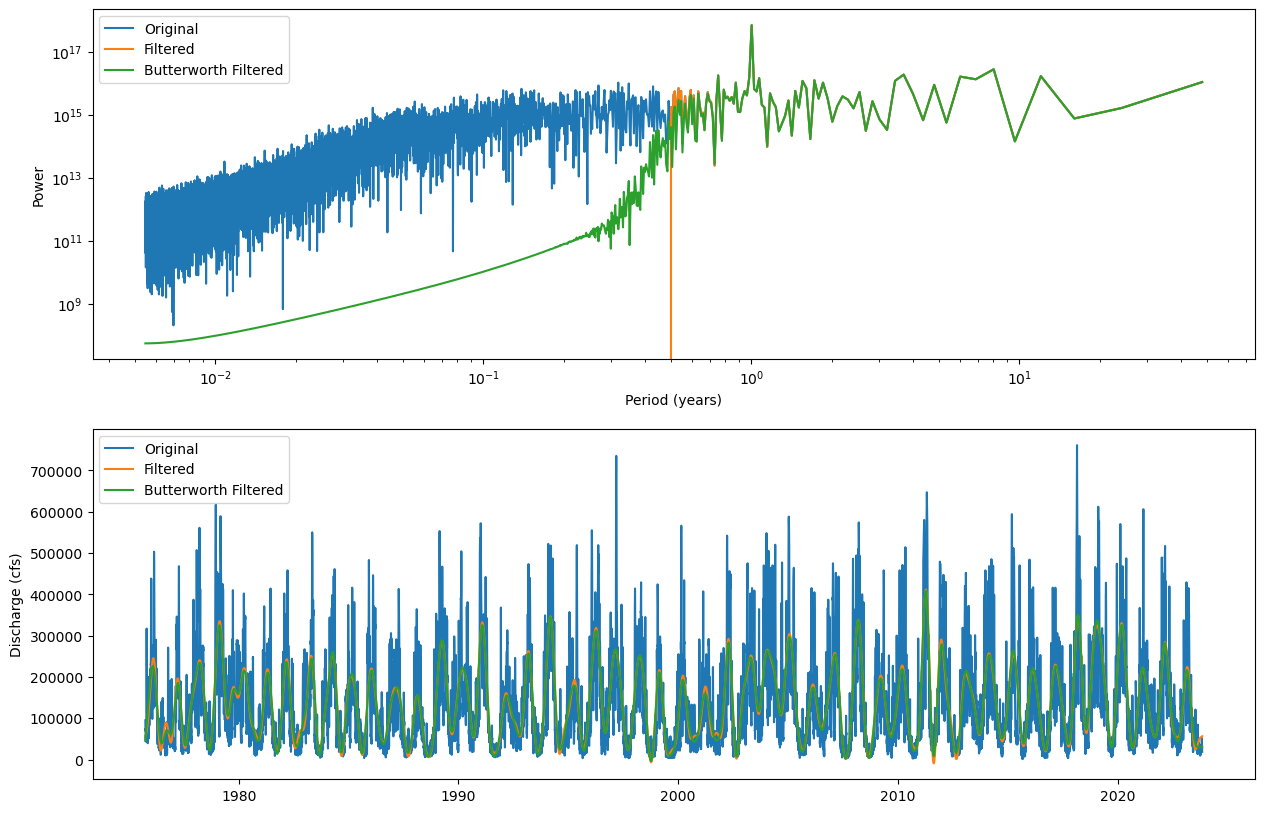

In [20]:
""" Filter the data using a Butterworth filter. """

from scipy.signal import butter, filtfilt

# set the cutoff period 
cutoff_period = 0.5 # years

# convert the cutoff period to a frequency
cutoff_freq = 1 / cutoff_period
cutoff_freq = cutoff_freq / (60*60*24*365.25)

# Calculate the Nyquist frequency
nyquist_freq = 1/(2*dt)
cutoff_freq_norm = cutoff_freq / nyquist_freq

# set filter order
filter_order = 5

# calculate the lowpass butterworth filter coefficents
b, a = butter(filter_order, cutoff_freq_norm, btype = 'lowpass')

# apply the filter
filtered_flow_butter = filtfilt(b, a, data['flow'])

# calculate the fft
filtered_flow_butter_fft = np.fft.rfft(filtered_flow_butter)

# ********************************************************************
# plot the power spectrum and timeseries
# for the original and filtered data
# ********************************************************************
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# the power spectrum 
ax = axs[0]
ax.plot(periods, np.abs(flow_fft * np.conj(flow_fft)), label = 'Original')
ax.plot(periods, np.abs(filtered_flow_fft * np.conj(filtered_flow_fft)), label = 'Filtered')
ax.plot(periods, np.abs(filtered_flow_butter_fft * np.conj(filtered_flow_butter_fft)), label = 'Butterworth Filtered')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Period (years)")
ax.set_ylabel("Power")
ax.legend()

# the time series 
ax = axs[1]
ax.plot(data['date'], data['flow'], label = 'Original')
ax.plot(data['date'], filtered_flow, label = 'Filtered')
ax.plot(data['date'], filtered_flow_butter, label = 'Butterworth Filtered')
ax.set_ylabel('Discharge (cfs)')
ax.legend()


plt.show()

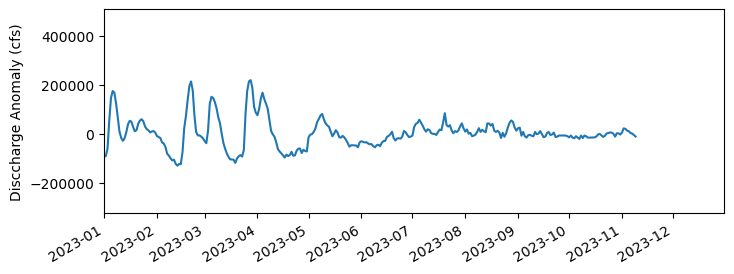

In [23]:
""" Calculate and plot the high-pass data """
flow_highpass = data['flow'] - filtered_flow_butter

fig, ax = plt.subplots(figsize = (8,3))

ax.plot(data['date'], flow_highpass)
ax.set_ylabel("Disccharge Anomaly (cfs)")

# zoom in on 2023
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31'))

# make the x-axis labels more readable
fig.autofmt_xdate()

plt.show()

